In [14]:
import psutil
import platform
from pynvml import *

# CPU Information
print(f"CPU: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} Physical, {psutil.cpu_count(logical=True)} Logical")

# RAM Information
ram = psutil.virtual_memory()
print(f"RAM: {ram.total / (1024**3):.2f} GB Total")
print(f"RAM Usage: {ram.used / (1024**3):.2f} GB Used ({ram.percent}%)")

# Display GPU info will be in the next cell with nvidia-smi


CPU: aarch64
CPU Cores: 64 Physical, 64 Logical
RAM: 525.68 GB Total
RAM Usage: 116.58 GB Used (28.5%)


In [15]:
!nvidia-smi

Mon Apr 28 08:20:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             On  |   00000000:DD:00.0 Off |                    0 |
| N/A   36C    P0            119W /  700W |   95688MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [25]:
import torch
import torch.nn as nn
from transformers import (
    RobertaTokenizer,
    Wav2Vec2FeatureExtractor,
    AutoModel,
    RobertaModel,
    HubertModel
)
import torch.optim as optim
import copy
import os
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score
# Add these imports to your first code block
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np # Ensure numpy is imported

try:
    from utils import get_iemocap_data_loaders, collate_fn_raw, MetricsLogger
    from models import TextOnlyModel, AudioOnlyModel
    from trainer import Trainer
    print("Successfully imported custom modules (utils, models, trainer).")
except ImportError as e:
    print(f"Error importing custom modules: {e}")
    print("Please ensure utils.py, models.py, and trainer.py exist and contain the necessary definitions.")

Successfully imported custom modules (utils, models, trainer).


In [17]:
# Check which GPU PyTorch is using
if torch.cuda.is_available():
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Device Count: {torch.cuda.device_count()}")
    print(f"Current Device Index: {torch.cuda.current_device()}")
    print(f"Device Capability: {torch.cuda.get_device_capability()}")
    print(f"GPU Memory Usage:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"  Cached: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
else:
    print("PyTorch is not using GPU - CUDA is not available")


PyTorch is using GPU: NVIDIA GH200 480GB
GPU Device Count: 1
Current Device Index: 0
Device Capability: (9, 0)
GPU Memory Usage:
  Allocated: 50.00 MB
  Cached: 94966.00 MB


In [18]:
import torch

# --- General Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')
torch.backends.cuda.matmul.allow_tf32 = False

# Emotion labels
EMOTION_LABELS = ['angry', 'frustrated', 'happy', 'sad', 'neutral']
NUM_CLASSES = len(EMOTION_LABELS)

# Model checkpoints
AUDIO_CHECKPOINT = 'facebook/hubert-base-ls960'
TEXT_CHECKPOINT = 'roberta-base'

# Data parameters
DATA_PATH = './iemocap'
PRECOMPUTED_FEATURES = False

# Training parameters
BATCH_SIZE = 32
NUM_WORKERS = 50
LEARNING_RATE = 3e-3
N_EPOCHS = 20
PATIENCE = 5
FREEZE_BASE_MODEL = True

print("\n--- Configuration ---")
print(f"Device: {DEVICE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Freeze base model: {FREEZE_BASE_MODEL}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Epochs: {N_EPOCHS}")
print(f"Patience: {PATIENCE}")

Using device: cuda

--- Configuration ---
Device: cuda
Number of classes: 5
Freeze base model: True
Batch Size: 32
Learning Rate: 0.003
Epochs: 20
Patience: 5


In [19]:
import torch
from transformers import RobertaTokenizer, Wav2Vec2FeatureExtractor

# --- Load Tokenizer and Processor ---
print("\nLoading tokenizer and feature extractor...")
try:
    tokenizer = RobertaTokenizer.from_pretrained(TEXT_CHECKPOINT)
    processor = Wav2Vec2FeatureExtractor.from_pretrained(AUDIO_CHECKPOINT)
    print("Tokenizer and feature extractor loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer/processor: {e}")
    raise RuntimeError("Failed to load tokenizer/processor.") from e

# --- Load Data Loaders ---
collate_wrapper = lambda b: collate_fn_raw(b, tokenizer, processor)

print("\nLoading data loaders...")
try:
    train_loader, val_loader, test_loader = get_iemocap_data_loaders(
        path=DATA_PATH,
        precomputed=PRECOMPUTED_FEATURES,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        collate_fn=collate_wrapper,
    )
    print("Data loaders created.")
    # Verify data loaders
    print("Checking a sample batch from train_loader...")
    sample_batch = next(iter(train_loader))
    print("Sample batch keys:", sample_batch.keys())
    if 'text_inputs' in sample_batch:
        print("Text input_ids shape:", sample_batch['text_inputs'].get('input_ids', torch.empty(0)).shape)
    if 'audio_inputs' in sample_batch:
        print("Audio input_values shape:", sample_batch['audio_inputs'].get('input_values', torch.empty(0)).shape)
    if 'labels' in sample_batch:
        print("Labels shape:", sample_batch['labels'].shape)

    # Store loaders for the function
    data_loaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }

except NameError:
     print("Error: `get_iemocap_data_loaders` or `collate_fn_raw` not found. Check imports.")
     raise RuntimeError("Data loading functions not found.")
except Exception as e:
    print(f"Error creating data loaders: {e}")
    raise RuntimeError("Failed to create data loaders.") from e


Loading tokenizer and feature extractor...


Tokenizer and feature extractor loaded successfully.

Loading data loaders...
Distribution after filtering:
neutral: 1726
frustrated: 2917
angry: 1269
sad: 1250
happy: 2632
train, val, test sizes: 7835, 979, 980
Data loaders created.
Checking a sample batch from train_loader...
Sample batch keys: dict_keys(['text_inputs', 'audio_inputs', 'labels'])
Text input_ids shape: torch.Size([32, 54])
Audio input_values shape: torch.Size([32, 223840])
Labels shape: torch.Size([32])


In [20]:
import torch
import torch.optim as optim
from transformers import AutoModel
import copy
import os
import traceback

def run_unimodal_training(model_type, device, config, data_loaders):
    """
    Encapsulates the training and evaluation process for a unimodal model.

    Args:
        model_type (str): 'text' or 'audio'.
        device (str): 'cuda' or 'cpu'.
        config (dict): Dictionary containing configuration parameters like
                       checkpoints, paths, training settings.
        data_loaders (dict): Dictionary containing 'train', 'val', 'test' DataLoaders.
    """
    print(f"\n{'='*20} Starting Training for {model_type.upper()} Model {'='*20}")

    # --- Configuration Specific to this Run ---
    if model_type == 'text':
        base_checkpoint = config['text_checkpoint']
        model_save_path = config['text_model_save_path']
        metrics_save_path = config['text_metrics_save_path']
        ModelClass = TextOnlyModel
    elif model_type == 'audio':
        base_checkpoint = config['audio_checkpoint']
        model_save_path = config['audio_model_save_path']
        metrics_save_path = config['audio_metrics_save_path']
        ModelClass = AudioOnlyModel
    else:
        raise ValueError("model_type must be 'text' or 'audio'")

    num_classes = config['num_classes']
    freeze_base = config['freeze_base_model']
    lr = config['learning_rate']
    n_epochs = config['n_epochs']
    patience = config['patience']

    # --- Instantiate Logger ---
    try:
        logger = MetricsLogger(save_path=metrics_save_path)
    except NameError:
        print("Error: MetricsLogger class not found. Check imports from utils.py.")
        return # Stop this run if logger is missing

    # --- Load Base Model ---
    print(f"Loading base pre-trained model: {base_checkpoint}...")
    try:
        base_model = AutoModel.from_pretrained(base_checkpoint)
    except Exception as e:
        print(f"Error loading base model {base_checkpoint}: {e}")
        return # Stop this run

    # --- Freeze Base Model Parameters ---
    if freeze_base:
        print("Freezing base model parameters.")
        for param in base_model.parameters():
            param.requires_grad = False
    else:
        print("Base model parameters will be fine-tuned.")

    # --- Instantiate Full Model ---
    print(f"Instantiating {model_type.capitalize()}OnlyModel...")
    hidden_size = base_model.config.hidden_size
    try:
        # Instantiate the specific model class
        if model_type == 'text':
             # Pass the actual loaded base_model instance
            model = ModelClass(roberta=base_model, num_classes=num_classes, hidden_size=hidden_size)
        elif model_type == 'audio':
             # Pass the actual loaded base_model instance
            model = ModelClass(hubert=base_model, num_classes=num_classes, hidden_size=hidden_size)
        print(f"{model_type.capitalize()}OnlyModel instantiated successfully.")
    except NameError:
         print(f"Error: {ModelClass.__name__} class not found. Check imports from models.py.")
         return # Stop this run if model class is missing
    except Exception as e:
        print(f"Error instantiating {ModelClass.__name__}: {e}")
        traceback.print_exc()
        return # Stop this run

    # --- Move Model to Device ---
    try:
        model.to(device)
    except Exception as e:
        print(f"Error moving model to device {device}: {e}")
        return # Stop this run

    # --- Set Up Optimizer ---
    params_to_optimize = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.AdamW(params_to_optimize, lr=lr)
    print(f"Optimizer: AdamW with LR={lr}")
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_trainable_params}")

    # --- Instantiate Trainer ---
    try:
        trainer = Trainer(model, optimizer, device=device)
    except NameError:
        print("Error: Trainer class not found. Check imports from trainer.py.")
        return # Stop this run

    # --- Training Loop ---
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0

    print(f"\nStarting training for {n_epochs} epochs...")
    for epoch in range(1, n_epochs + 1):
        try:
            # Train
            train_loss, train_acc, train_f1 = trainer.train_one_epoch(data_loaders['train'], epoch)
            # Validate
            val_loss, val_acc, val_f1 = trainer.evaluate(data_loaders['val'], desc="Validate")

            print(f'\nEpoch {epoch}/{n_epochs}')
            print(f'  [Train] Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}')
            print(f'  [Val]   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}')

            # Log metrics
            logger.log_train(train_loss, train_acc, train_f1)
            logger.log_val(val_loss, val_acc, val_f1)
            logger.save()

            # Check for improvement and save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(trainer.model.state_dict())
                early_stopping_counter = 0
                print(f'  -> Validation loss improved to {best_val_loss:.4f}. Saving model state.')
                try:
                     torch.save({
                        'epoch': epoch,
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': best_val_loss,
                        'config': {
                             'model_type': model_type,
                             'num_classes': num_classes,
                             'hidden_size': hidden_size,
                             'base_checkpoint': base_checkpoint
                        }
                    }, model_save_path)
                     print(f"  -> Best model checkpoint saved to '{model_save_path}'")
                except Exception as e_save:
                    print(f"  -> Error saving model checkpoint: {e_save}")
            else:
                early_stopping_counter += 1
                print(f'  -> Validation loss did not improve. Counter: {early_stopping_counter}/{patience}')

            # Early stopping
            if early_stopping_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch} epochs.')
                break
        except Exception as e_epoch:
            print(f"\nError during epoch {epoch}: {e_epoch}")
            traceback.print_exc()
            print("Stopping training for this model type due to error.")
            return # Stop this run

    print("\nTraining finished.")

    # --- Final Evaluation on Test Set ---
    print(f"\n--- Evaluating Best {model_type.upper()} Model on Test Set ---")
    if best_model_state is None:
         print("Warning: No best model state was saved (validation loss might not have improved). Evaluating last model state.")
         # Ensure the model used by the trainer is used for evaluation
         eval_model = trainer.model # Use the model instance from the trainer
         eval_model.eval() # Set to eval mode
    elif not os.path.exists(model_save_path):
        print(f"Warning: Best model checkpoint '{model_save_path}' not found, but best state exists in memory. Evaluating model from memory.")
        # Need to load the state into the current model instance
        try:
            model.load_state_dict(best_model_state)
            eval_model = model
            eval_model.eval()
        except Exception as e_load_mem:
             print(f"Error loading best model state from memory: {e_load_mem}. Cannot evaluate.")
             return
    else:
        print(f"Loading best model state from '{model_save_path}'...")
        try:
            checkpoint = torch.load(model_save_path, map_location=device)
            # Re-initialize architecture - important if script restarted or for consistency
            print("Re-initializing model architecture for evaluation...")
            eval_config = checkpoint.get('config', {})
            eval_num_classes = eval_config.get('num_classes', num_classes)
            eval_base_checkpoint = eval_config.get('base_checkpoint', base_checkpoint)
            eval_base_model = AutoModel.from_pretrained(eval_base_checkpoint)
            eval_hidden_size = eval_config.get('hidden_size', eval_base_model.config.hidden_size)

            if model_type == 'text':
                 eval_model = TextOnlyModel(roberta=eval_base_model, num_classes=eval_num_classes, hidden_size=eval_hidden_size)
            elif model_type == 'audio':
                 eval_model = AudioOnlyModel(hubert=eval_base_model, num_classes=eval_num_classes, hidden_size=eval_hidden_size)

            eval_model.load_state_dict(checkpoint['model_state_dict'])
            eval_model.to(device)
            eval_model.eval()
            print("Best model loaded successfully from file.")

        except FileNotFoundError:
            print(f"Error: Checkpoint file not found at {model_save_path}. Cannot evaluate.")
            return
        except Exception as e_load:
            print(f"An error occurred loading the best model: {e_load}")
            traceback.print_exc()
            return

    # Use the existing Trainer instance structure for evaluation, but with the loaded/best model
    # Create a dummy optimizer as Trainer expects one, but it won't be used for eval
    eval_optimizer = optim.AdamW(eval_model.parameters(), lr=1e-5)
    eval_trainer = Trainer(eval_model, eval_optimizer, device=device)

    print("\nRunning evaluation on the test set...")
    try:
        test_loss, test_acc, test_f1 = eval_trainer.evaluate(data_loaders['test'], desc="Test")

        print("\n--- Test Set Results ---")
        print(f"  Loss: {test_loss:.4f}")
        print(f"  Accuracy: {test_acc:.4f}")
        print(f"  Weighted F1-Score: {test_f1:.4f}")

        # Log test results
        logger.log_test(test_loss, test_acc, test_f1)
        logger.save()
        print(f"Test metrics logged and saved to {logger.save_path}")

    except Exception as e_eval:
        print(f"An error occurred during final evaluation: {e_eval}")
        traceback.print_exc()

    print(f"\n{'='*20} Finished Run for {model_type.upper()} Model {'='*20}")


print("Training and evaluation function defined.")

Training and evaluation function defined.


In [22]:
# --- Define Configuration for the Run ---
# Using variables defined in Block 2
run_config_text = {
    'text_checkpoint': TEXT_CHECKPOINT,
    'audio_checkpoint': AUDIO_CHECKPOINT, # Keep both for potential future use in config
    'text_model_save_path': 'best_text_only_model.pth',
    'text_metrics_save_path': 'text_only_training_metrics.json',
    'audio_model_save_path': 'best_audio_only_model.pth', # Keep both for consistency
    'audio_metrics_save_path': 'audio_only_training_metrics.json',
    'num_classes': NUM_CLASSES,
    'freeze_base_model': FREEZE_BASE_MODEL,
    'learning_rate': LEARNING_RATE,
    'n_epochs': N_EPOCHS,
    'patience': PATIENCE,
}

# --- Run Training for Text Model ---
try:
    # Pass necessary variables: model type, device, config dict, data loaders dict
    run_unimodal_training(
        model_type='text',
        device=DEVICE,
        config=run_config_text,
        data_loaders=data_loaders # data_loaders defined in Block 3
    )
except NameError as e:
    print(f"Error calling training function for TEXT model: Required variable not defined ({e}). Check previous blocks.")
except Exception as e:
    print(f"An unexpected error occurred during TEXT model training execution: {e}")
    traceback.print_exc()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==================== Starting Training for TEXT Model ====================
Loading base pre-trained model: roberta-base...
Freezing base model parameters.
Instantiating TextOnlyModel...
TextOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
TextOnlyModel instantiated successfully.
Optimizer: AdamW with LR=0.003
Number of trainable parameters: 1185029

Starting training for 20 epochs...


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.59it/s]



Epoch 1/20
  [Train] Loss: 1.5646 | Acc: 0.2930 | F1: 0.2089
  [Val]   Loss: 1.5470 | Acc: 0.2758 | F1: 0.1192
  -> Validation loss improved to 1.5470. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.99it/s]



Epoch 2/20
  [Train] Loss: 1.5334 | Acc: 0.3193 | F1: 0.2438
  [Val]   Loss: 1.4759 | Acc: 0.3626 | F1: 0.2602
  -> Validation loss improved to 1.4759. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.87it/s]



Epoch 3/20
  [Train] Loss: 1.4860 | Acc: 0.3567 | F1: 0.2888
  [Val]   Loss: 1.4453 | Acc: 0.3575 | F1: 0.2832
  -> Validation loss improved to 1.4453. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 17.15it/s]



Epoch 4/20
  [Train] Loss: 1.4657 | Acc: 0.3657 | F1: 0.3068
  [Val]   Loss: 1.4204 | Acc: 0.4025 | F1: 0.3316
  -> Validation loss improved to 1.4204. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.83it/s]



Epoch 5/20
  [Train] Loss: 1.4588 | Acc: 0.3680 | F1: 0.3054
  [Val]   Loss: 1.4422 | Acc: 0.4096 | F1: 0.3398
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 17.03it/s]



Epoch 6/20
  [Train] Loss: 1.4502 | Acc: 0.3757 | F1: 0.3149
  [Val]   Loss: 1.3727 | Acc: 0.4127 | F1: 0.3649
  -> Validation loss improved to 1.3727. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.99it/s]



Epoch 7/20
  [Train] Loss: 1.4360 | Acc: 0.3752 | F1: 0.3267
  [Val]   Loss: 1.3793 | Acc: 0.4004 | F1: 0.3244
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 17.03it/s]



Epoch 8/20
  [Train] Loss: 1.4368 | Acc: 0.3768 | F1: 0.3211
  [Val]   Loss: 1.3925 | Acc: 0.4321 | F1: 0.3330
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 16.99it/s]



Epoch 9/20
  [Train] Loss: 1.4266 | Acc: 0.3779 | F1: 0.3246
  [Val]   Loss: 1.3333 | Acc: 0.4372 | F1: 0.3471
  -> Validation loss improved to 1.3333. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 17.02it/s]



Epoch 10/20
  [Train] Loss: 1.4298 | Acc: 0.3838 | F1: 0.3384
  [Val]   Loss: 1.3576 | Acc: 0.4362 | F1: 0.3590
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.92it/s]



Epoch 11/20
  [Train] Loss: 1.4283 | Acc: 0.3825 | F1: 0.3316
  [Val]   Loss: 1.3319 | Acc: 0.4372 | F1: 0.3815
  -> Validation loss improved to 1.3319. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.91it/s]



Epoch 12/20
  [Train] Loss: 1.4266 | Acc: 0.3851 | F1: 0.3348
  [Val]   Loss: 1.3124 | Acc: 0.4464 | F1: 0.3771
  -> Validation loss improved to 1.3124. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.65it/s]



Epoch 13/20
  [Train] Loss: 1.4309 | Acc: 0.3820 | F1: 0.3341
  [Val]   Loss: 1.3527 | Acc: 0.4096 | F1: 0.3244
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.80it/s]



Epoch 14/20
  [Train] Loss: 1.4210 | Acc: 0.3792 | F1: 0.3324
  [Val]   Loss: 1.3251 | Acc: 0.4249 | F1: 0.3538
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.60it/s]



Epoch 15/20
  [Train] Loss: 1.4135 | Acc: 0.3805 | F1: 0.3407
  [Val]   Loss: 1.3309 | Acc: 0.4464 | F1: 0.4087
  -> Validation loss did not improve. Counter: 3/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.80it/s]



Epoch 16/20
  [Train] Loss: 1.4146 | Acc: 0.3895 | F1: 0.3481
  [Val]   Loss: 1.3021 | Acc: 0.4494 | F1: 0.4215
  -> Validation loss improved to 1.3021. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.93it/s]



Epoch 17/20
  [Train] Loss: 1.4138 | Acc: 0.3852 | F1: 0.3491
  [Val]   Loss: 1.3717 | Acc: 0.4259 | F1: 0.3956
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.79it/s]



Epoch 18/20
  [Train] Loss: 1.4088 | Acc: 0.3872 | F1: 0.3467
  [Val]   Loss: 1.3068 | Acc: 0.4576 | F1: 0.4205
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.81it/s]



Epoch 19/20
  [Train] Loss: 1.4117 | Acc: 0.3881 | F1: 0.3550
  [Val]   Loss: 1.3215 | Acc: 0.4402 | F1: 0.3922
  -> Validation loss did not improve. Counter: 3/5


Validate: 100%|██████████| 31/31 [00:01<00:00, 19.89it/s]



Epoch 20/20
  [Train] Loss: 1.3954 | Acc: 0.4003 | F1: 0.3726
  [Val]   Loss: 1.2973 | Acc: 0.4688 | F1: 0.4110
  -> Validation loss improved to 1.2973. Saving model state.
  -> Best model checkpoint saved to 'best_text_only_model.pth'

Training finished.

--- Evaluating Best TEXT Model on Test Set ---
Loading best model state from 'best_text_only_model.pth'...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Re-initializing model architecture for evaluation...
TextOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
Best model loaded successfully from file.

Running evaluation on the test set...


Test: 100%|██████████| 31/31 [00:01<00:00, 20.26it/s]


--- Test Set Results ---
  Loss: 1.3139
  Accuracy: 0.4510
  Weighted F1-Score: 0.3983
Test metrics logged and saved to text_only_training_metrics.json

==================== Finished Run for TEXT Model ====================


In [21]:
# Free up memory from previous model training
import torch
import gc

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Run garbage collection to free up memory
gc.collect()

print("Memory cleared from previous model training.")


# --- Define Configuration for the Run ---
# Re-use most config, paths are handled inside the function based on model_type
run_config_audio = {
    'text_checkpoint': TEXT_CHECKPOINT,
    'audio_checkpoint': AUDIO_CHECKPOINT,
    'text_model_save_path': 'best_text_only_model.pth',
    'text_metrics_save_path': 'text_only_training_metrics.json',
    'audio_model_save_path': 'best_audio_only_model.pth',
    'audio_metrics_save_path': 'audio_only_training_metrics.json',
    'num_classes': NUM_CLASSES,
    'freeze_base_model': FREEZE_BASE_MODEL,
    'learning_rate': LEARNING_RATE,
    'n_epochs': N_EPOCHS,
    'patience': PATIENCE,
}

# --- Run Training for Audio Model ---
try:
     # Pass necessary variables: model type, device, config dict, data loaders dict
    run_unimodal_training(
        model_type='audio',
        device=DEVICE,
        config=run_config_audio,
        data_loaders=data_loaders # data_loaders defined in Block 3
    )
except NameError as e:
    print(f"Error calling training function for AUDIO model: Required variable not defined ({e}). Check previous blocks.")
except Exception as e:
    print(f"An unexpected error occurred during AUDIO model training execution: {e}")
    traceback.print_exc()

print("\n--- All Training Runs Complete ---")

Memory cleared from previous model training.

==================== Starting Training for AUDIO Model ====================
Loading base pre-trained model: facebook/hubert-base-ls960...
Freezing base model parameters.
Instantiating AudioOnlyModel...
AudioOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
AudioOnlyModel instantiated successfully.
Optimizer: AdamW with LR=0.003
Number of trainable parameters: 1185029

Starting training for 20 epochs...


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.68it/s]



Epoch 1/20
  [Train] Loss: 1.4916 | Acc: 0.3124 | F1: 0.2841
  [Val]   Loss: 1.5568 | Acc: 0.2707 | F1: 0.2423
  -> Validation loss improved to 1.5568. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 2/20
  [Train] Loss: 1.4415 | Acc: 0.3330 | F1: 0.3131
  [Val]   Loss: 1.3991 | Acc: 0.3800 | F1: 0.3491
  -> Validation loss improved to 1.3991. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.46it/s]



Epoch 3/20
  [Train] Loss: 1.4200 | Acc: 0.3493 | F1: 0.3295
  [Val]   Loss: 1.4160 | Acc: 0.3636 | F1: 0.3289
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.67it/s]



Epoch 4/20
  [Train] Loss: 1.3981 | Acc: 0.3639 | F1: 0.3445
  [Val]   Loss: 1.3318 | Acc: 0.4331 | F1: 0.4025
  -> Validation loss improved to 1.3318. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.40it/s]



Epoch 5/20
  [Train] Loss: 1.3885 | Acc: 0.3765 | F1: 0.3555
  [Val]   Loss: 1.3371 | Acc: 0.4259 | F1: 0.4027
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.69it/s]



Epoch 6/20
  [Train] Loss: 1.3573 | Acc: 0.3937 | F1: 0.3752
  [Val]   Loss: 1.3508 | Acc: 0.3953 | F1: 0.3537
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]



Epoch 7/20
  [Train] Loss: 1.3637 | Acc: 0.3991 | F1: 0.3822
  [Val]   Loss: 1.3376 | Acc: 0.4157 | F1: 0.3828
  -> Validation loss did not improve. Counter: 3/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.44it/s]



Epoch 8/20
  [Train] Loss: 1.3482 | Acc: 0.4019 | F1: 0.3906
  [Val]   Loss: 1.2814 | Acc: 0.4709 | F1: 0.4312
  -> Validation loss improved to 1.2814. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.48it/s]



Epoch 9/20
  [Train] Loss: 1.3455 | Acc: 0.4061 | F1: 0.3890
  [Val]   Loss: 1.3914 | Acc: 0.3687 | F1: 0.3132
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.20it/s]



Epoch 10/20
  [Train] Loss: 1.3376 | Acc: 0.4154 | F1: 0.3997
  [Val]   Loss: 1.2757 | Acc: 0.4709 | F1: 0.4535
  -> Validation loss improved to 1.2757. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.43it/s]



Epoch 11/20
  [Train] Loss: 1.3207 | Acc: 0.4257 | F1: 0.4127
  [Val]   Loss: 1.3347 | Acc: 0.4229 | F1: 0.3618
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:06<00:00,  5.13it/s]



Epoch 12/20
  [Train] Loss: 1.3306 | Acc: 0.4180 | F1: 0.4050
  [Val]   Loss: 1.2794 | Acc: 0.4505 | F1: 0.4229
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:06<00:00,  5.11it/s]



Epoch 13/20
  [Train] Loss: 1.3129 | Acc: 0.4258 | F1: 0.4112
  [Val]   Loss: 1.2929 | Acc: 0.4831 | F1: 0.4658
  -> Validation loss did not improve. Counter: 3/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.28it/s]



Epoch 14/20
  [Train] Loss: 1.3166 | Acc: 0.4194 | F1: 0.4052
  [Val]   Loss: 1.2913 | Acc: 0.4341 | F1: 0.4136
  -> Validation loss did not improve. Counter: 4/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.27it/s]



Epoch 15/20
  [Train] Loss: 1.3090 | Acc: 0.4331 | F1: 0.4229
  [Val]   Loss: 1.2444 | Acc: 0.4780 | F1: 0.4391
  -> Validation loss improved to 1.2444. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.26it/s]



Epoch 16/20
  [Train] Loss: 1.3114 | Acc: 0.4268 | F1: 0.4138
  [Val]   Loss: 1.2637 | Acc: 0.4576 | F1: 0.4421
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:06<00:00,  5.09it/s]



Epoch 17/20
  [Train] Loss: 1.2996 | Acc: 0.4329 | F1: 0.4213
  [Val]   Loss: 1.2767 | Acc: 0.4688 | F1: 0.4393
  -> Validation loss did not improve. Counter: 2/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.32it/s]



Epoch 18/20
  [Train] Loss: 1.3041 | Acc: 0.4357 | F1: 0.4216
  [Val]   Loss: 1.2386 | Acc: 0.4842 | F1: 0.4645
  -> Validation loss improved to 1.2386. Saving model state.
  -> Best model checkpoint saved to 'best_audio_only_model.pth'


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.25it/s]



Epoch 19/20
  [Train] Loss: 1.3024 | Acc: 0.4328 | F1: 0.4205
  [Val]   Loss: 1.2681 | Acc: 0.4770 | F1: 0.4574
  -> Validation loss did not improve. Counter: 1/5


Validate: 100%|██████████| 31/31 [00:05<00:00,  5.19it/s]



Epoch 20/20
  [Train] Loss: 1.2923 | Acc: 0.4281 | F1: 0.4164
  [Val]   Loss: 1.2460 | Acc: 0.4545 | F1: 0.4291
  -> Validation loss did not improve. Counter: 2/5

Training finished.

--- Evaluating Best AUDIO Model on Test Set ---
Loading best model state from 'best_audio_only_model.pth'...
Re-initializing model architecture for evaluation...
AudioOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
Best model loaded successfully from file.

Running evaluation on the test set...


Test: 100%|██████████| 31/31 [00:05<00:00,  6.00it/s]


--- Test Set Results ---
  Loss: 1.2644
  Accuracy: 0.4633
  Weighted F1-Score: 0.4430
Test metrics logged and saved to audio_only_training_metrics.json

==================== Finished Run for AUDIO Model ====================

--- All Training Runs Complete ---


In [26]:
# Block: Helper function to get predictions and labels for Confusion Matrix

import torch
from tqdm import tqdm # Or tqdm.notebook

@torch.no_grad() # Ensure gradients are not calculated
def get_predictions_and_labels(model, loader, device):
    """
    Runs inference on the data loader and returns true labels and predictions.

    Args:
        model (nn.Module): The trained model (already on the correct device).
        loader (DataLoader): The DataLoader for the test set.
        device (str or torch.device): The device to run inference on.

    Returns:
        tuple: (list of true labels, list of predicted labels)
    """
    model.eval() # Set model to evaluation mode
    all_preds = []
    all_labels = []
    print(f"Getting predictions for confusion matrix using device: {device}")
    loop = tqdm(loader, desc="Predicting", leave=False)

    for batch in loop:
        # Ensure batch structure is correct and move data
        if 'text_inputs' not in batch or 'audio_inputs' not in batch or 'labels' not in batch:
             print(f"Warning: Skipping batch due to missing keys. Found: {batch.keys()}")
             continue

        try:
            # Move data to device (similar to Trainer.step, but without loss calc)
            text_inputs = {
                k: (v.to(device).bool() if k == 'attention_mask' else v.to(device))
                for k, v in batch['text_inputs'].items() if isinstance(v, torch.Tensor)
            }
            audio_inputs = {
                k: v.to(device)
                for k, v in batch['audio_inputs'].items() if isinstance(v, torch.Tensor)
            }
            labels = batch['labels'].to(device)

            # Get model logits using the compatible forward pass
            logits = model(text_inputs, audio_inputs)
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

        except Exception as e:
            print(f"\nError during prediction step: {e}")
            print(f"Problematic batch keys: {batch.keys()}")
            # Decide whether to skip or stop
            continue # Skip batch on error

    print(f"Finished predicting. Got {len(all_labels)} labels and {len(all_preds)} predictions.")
    if len(all_labels) != len(all_preds):
        print("Warning: Mismatch between number of labels and predictions collected.")

    return all_labels, all_preds

print("Helper function 'get_predictions_and_labels' defined.")

Helper function 'get_predictions_and_labels' defined.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Generating Final Confusion Matrices for Saved Models ---

--- Processing Text Model ---
Loading model state from 'best_text_only_model.pth'...
Re-initializing model architecture for evaluation...
  Using config - Num Classes: 5, Base: roberta-base
TextOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
Model loaded successfully from file.

Generating Confusion Matrix for Text Model...
Getting predictions for confusion matrix using device: cuda


Finished predicting. Got 980 labels and 980 predictions.

Classification Report:
              precision    recall  f1-score   support

       angry     0.4583    0.1009    0.1654       109
  frustrated     0.3951    0.7427    0.5158       307
       happy     0.5304    0.6171    0.5704       269
         sad     0.5333    0.1176    0.1928       136
     neutral     0.5833    0.1321    0.2154       159

    accuracy                         0.4510       980
   macro avg     0.5001    0.3421    0.3320       980
weighted avg     0.4890    0.4510    0.3983       980

Confusion matrix saved to final_confusion_matrix_text.png


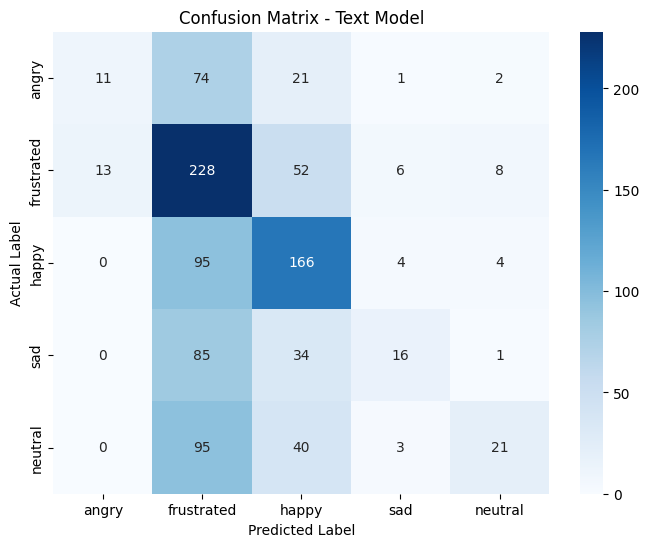


--- Processing Audio Model ---
Loading model state from 'best_audio_only_model.pth'...
Re-initializing model architecture for evaluation...
  Using config - Num Classes: 5, Base: facebook/hubert-base-ls960
AudioOnlyModel initialized (compatible version) with hidden_size=768, num_classes=5
Model loaded successfully from file.

Generating Confusion Matrix for Audio Model...
Getting predictions for confusion matrix using device: cuda


Finished predicting. Got 980 labels and 980 predictions.

Classification Report:
              precision    recall  f1-score   support

       angry     0.4865    0.1651    0.2466       109
  frustrated     0.4450    0.5537    0.4935       307
       happy     0.5351    0.5390    0.5370       269
         sad     0.4236    0.6324    0.5074       136
     neutral     0.3333    0.1824    0.2358       159

    accuracy                         0.4571       980
   macro avg     0.4447    0.4145    0.4040       980
weighted avg     0.4533    0.4571    0.4381       980

Confusion matrix saved to final_confusion_matrix_audio.png


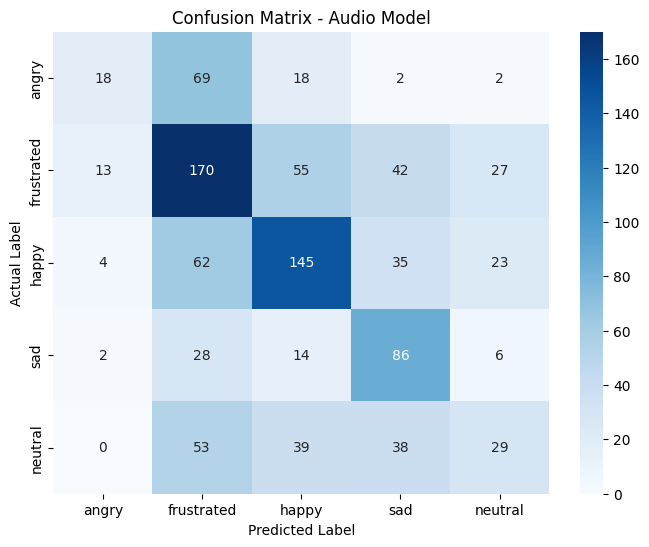


--- Confusion Matrix Generation Complete ---


In [28]:
# Block 7: Final Confusion Matrix Generation (Run After Training)

import torch
from transformers import AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import os
import traceback

print("\n--- Generating Final Confusion Matrices for Saved Models ---")

# --- Configuration & Variables Needed (Assumed from previous blocks) ---
# DEVICE, TEXT_CHECKPOINT, AUDIO_CHECKPOINT, NUM_CLASSES, EMOTION_LABELS
# test_loader
# TextOnlyModel, AudioOnlyModel classes
# get_predictions_and_labels function

model_configs = {
    'text': {
        'model_class': TextOnlyModel,
        'checkpoint_path': 'best_text_only_model.pth',
        'base_checkpoint_fallback': TEXT_CHECKPOINT,
        'title': 'Text Model'
    },
    'audio': {
        'model_class': AudioOnlyModel,
        'checkpoint_path': 'best_audio_only_model.pth',
        'base_checkpoint_fallback': AUDIO_CHECKPOINT,
        'title': 'Audio Model'
    }
}

# --- Loop through each model type ---
for model_type, config in model_configs.items():
    print(f"\n--- Processing {config['title']} ---")
    model_path = config['checkpoint_path']
    ModelClass = config['model_class']
    loaded_eval_model = None # Reset for each model type

    if not os.path.exists(model_path):
        print(f"Error: Model checkpoint '{model_path}' not found. Cannot generate confusion matrix.")
        continue # Skip to the next model type

    print(f"Loading model state from '{model_path}'...")
    try:
        checkpoint = torch.load(model_path, map_location=DEVICE)
        print("Re-initializing model architecture for evaluation...")

        # Load config from checkpoint if available, otherwise use current script's config
        eval_config = checkpoint.get('config', {})
        eval_num_classes = eval_config.get('num_classes', NUM_CLASSES)
        eval_base_checkpoint = eval_config.get('base_checkpoint', config['base_checkpoint_fallback'])
        # Use labels from checkpoint if saved, otherwise use current script's labels
        eval_emotion_labels = eval_config.get('emotion_labels', EMOTION_LABELS)

        eval_base_model = AutoModel.from_pretrained(eval_base_checkpoint)
        eval_hidden_size = eval_config.get('hidden_size', eval_base_model.config.hidden_size)

        print(f"  Using config - Num Classes: {eval_num_classes}, Base: {eval_base_checkpoint}")

        # Instantiate the correct model class
        if model_type == 'text':
             loaded_eval_model = ModelClass(roberta=eval_base_model, num_classes=eval_num_classes, hidden_size=eval_hidden_size)
        elif model_type == 'audio':
             loaded_eval_model = ModelClass(hubert=eval_base_model, num_classes=eval_num_classes, hidden_size=eval_hidden_size)

        loaded_eval_model.load_state_dict(checkpoint['model_state_dict'])
        loaded_eval_model.to(DEVICE)
        loaded_eval_model.eval() # Set to evaluation mode
        print("Model loaded successfully from file.")

    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {model_path}.")
        continue # Skip to next model
    except NameError as e:
         print(f"Error loading model: Required class {ModelClass.__name__} not found ({e}). Make sure it's defined.")
         continue
    except Exception as e_load:
        print(f"An error occurred loading the model from file: {e_load}")
        traceback.print_exc()
        continue # Skip to next model

    # --- Generate Predictions and Confusion Matrix ---
    if loaded_eval_model is not None:
        print(f"\nGenerating Confusion Matrix for {config['title']}...")
        try:
            # Use the helper function (must be defined in the environment)
            true_labels, pred_labels = get_predictions_and_labels(
                model=loaded_eval_model,
                loader=test_loader, # Assumes test_loader is available
                device=DEVICE
            )

            if not true_labels or not pred_labels:
                 print("Could not generate confusion matrix because no predictions were collected.")
            else:
                # Use the emotion labels determined during loading
                current_emotion_labels = eval_emotion_labels

                print("\nClassification Report:")
                print(classification_report(true_labels, pred_labels, target_names=current_emotion_labels, digits=4, zero_division=0))

                cm = confusion_matrix(true_labels, pred_labels, labels=range(len(current_emotion_labels))) # Ensure order matches labels
                cm_df = pd.DataFrame(cm, index=current_emotion_labels, columns=current_emotion_labels)

                plt.figure(figsize=(8, 6))
                sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix - {config["title"]}')
                plt.ylabel('Actual Label')
                plt.xlabel('Predicted Label')

                # Save the plot
                cm_filename = f"final_confusion_matrix_{model_type}.png"
                try:
                    plt.savefig(cm_filename)
                    print(f"Confusion matrix saved to {cm_filename}")
                except Exception as e_save_fig:
                    print(f"Error saving confusion matrix plot: {e_save_fig}")
                plt.show() # Display the plot

        except NameError as e_cm:
             print(f"Error generating confusion matrix: Required function 'get_predictions_and_labels' not found ({e_cm}).")
        except Exception as e_cm_other:
            print(f"An error occurred during confusion matrix generation: {e_cm_other}")
            traceback.print_exc()
    else:
        print(f"Skipping confusion matrix for {config['title']} as model failed to load.")

print("\n--- Confusion Matrix Generation Complete ---")